In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from preprocessing import vocab_size
import matplotlib.pyplot as plt
from tensorflow import keras
from model_definition import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

2023-04-04 16:10:46.928742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:10:47.041256: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 16:10:48.828301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/us

### Import the Data

Load in different data splits from files

In [2]:
with open('./data/train_cleaned_routes', 'rb') as f:
    X_train, y_train = pickle.load(f).values()
with open('./data/test_cleaned_routes', 'rb') as f:
    X_test, y_test = pickle.load(f).values()
with open('./data/val_cleaned_routes', 'rb') as f:
    X_val, y_val = pickle.load(f).values()

Mask Grade with CLS token

In [3]:
X_train[:, 0] = 3
X_test[:, 0] = 3
X_val[:, 0] = 3

In [4]:
np.shape(X_train)

(13510, 22)

In [5]:
X_train[0]

array([  3,   5,   6,  72, 101, 149, 161, 215,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

### Model Training

In [6]:
num_layers = 4
d_model = 128
dff = 2048
num_heads = 12
dropout_rate = 0.3
epochs = 100
warmup_steps = 4000

num_classes = len(np.unique(y_train))
batch_size = 128
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train) 
class_weights=dict(zip(np.unique(y_train), class_weights))

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

2023-04-04 16:10:51.985706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:10:53.285063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13641 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:61:00.0, compute capability: 7.5
2023-04-04 16:10:53.286839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13641 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:db:00.0, compute capability: 7.5


In [8]:
def get_compiled_model():    
    learning_rate = transformerSchedule(d_model, warmup_steps=warmup_steps, scalar=0.07)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.99, epsilon=1e-9, amsgrad = True)
    
    model = EncoderClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        activation='selu',
        sequential=True
    )
    
    model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=optimizer,
            metrics=['accuracy'])
    
    return model

In [10]:
import os
checkpoint_path = "model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callback = [tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, 
            save_weights_only=True,
            monitor='val_accuracy',
            save_best_only=True,
            initial_value_threshold=0.49,
            verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir="./logs")]

In [11]:
model = get_compiled_model()
model.build((13510, 22))
model.summary()

Model: "encoder_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  33993152  
                                                                 
 sequential_8 (Sequential)   (13510, 22, 128)          82304     
                                                                 
 dense_18 (Dense)            multiple                  1161      
                                                                 
Total params: 34,076,617
Trainable params: 34,076,617
Non-trainable params: 0
_________________________________________________________________


In [12]:
model = get_compiled_model()
history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, \
                        validation_data=val_dataset, class_weight=class_weights,verbose=1, callbacks = [my_callback])

Epoch 1/100


2023-04-01 10:25:57.355755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-01 10:25:57.597850: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x37c7f800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-01 10:25:57.597938: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-04-01 10:25:57.597962: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2023-04-01 10:25:57.597982: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2023-04-01 10:25:57.598008: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5
2023-04-01 10:25:57.607272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set e

106/106 [==============================] - ETA: 0s - loss: 3.0593 - accuracy: 0.1087
Epoch 1: val_accuracy did not improve from 0.49000
106/106 [==============================] - 55s 329ms/step - loss: 3.0593 - accuracy: 0.1087 - val_loss: 2.1921 - val_accuracy: 0.1828
Epoch 2/100
106/106 [==============================] - ETA: 0s - loss: 2.6903 - accuracy: 0.1118
Epoch 2: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 320ms/step - loss: 2.6903 - accuracy: 0.1118 - val_loss: 2.1675 - val_accuracy: 0.0444
Epoch 3/100
106/106 [==============================] - ETA: 0s - loss: 2.5166 - accuracy: 0.1259
Epoch 3: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 322ms/step - loss: 2.5166 - accuracy: 0.1259 - val_loss: 1.9792 - val_accuracy: 0.1625
Epoch 4/100
106/106 [==============================] - ETA: 0s - loss: 2.1016 - accuracy: 0.2291
Epoch 4: val_accuracy did not improve from 0.49000
106/106 [=========

Epoch 30/100
106/106 [==============================] - ETA: 0s - loss: 1.1505 - accuracy: 0.4865
Epoch 30: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 319ms/step - loss: 1.1505 - accuracy: 0.4865 - val_loss: 1.4378 - val_accuracy: 0.4119
Epoch 31/100
106/106 [==============================] - ETA: 0s - loss: 1.1475 - accuracy: 0.4887
Epoch 31: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 320ms/step - loss: 1.1475 - accuracy: 0.4887 - val_loss: 1.4052 - val_accuracy: 0.4060
Epoch 32/100
106/106 [==============================] - ETA: 0s - loss: 1.1393 - accuracy: 0.4913
Epoch 32: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 319ms/step - loss: 1.1393 - accuracy: 0.4913 - val_loss: 1.3656 - val_accuracy: 0.4334
Epoch 33/100
106/106 [==============================] - ETA: 0s - loss: 1.1296 - accuracy: 0.4947
Epoch 33: val_accuracy did not improve from 0.4900

Epoch 59/100
106/106 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.5283
Epoch 59: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 320ms/step - loss: 0.9891 - accuracy: 0.5283 - val_loss: 1.3325 - val_accuracy: 0.4510
Epoch 60/100
106/106 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.5357
Epoch 60: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 319ms/step - loss: 0.9818 - accuracy: 0.5357 - val_loss: 1.3562 - val_accuracy: 0.4484
Epoch 61/100
106/106 [==============================] - ETA: 0s - loss: 0.9730 - accuracy: 0.5360
Epoch 61: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 320ms/step - loss: 0.9730 - accuracy: 0.5360 - val_loss: 1.3687 - val_accuracy: 0.4419
Epoch 62/100
106/106 [==============================] - ETA: 0s - loss: 0.9804 - accuracy: 0.5343
Epoch 62: val_accuracy did not improve from 0.4900

Epoch 88/100
106/106 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.5614
Epoch 88: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 319ms/step - loss: 0.8864 - accuracy: 0.5614 - val_loss: 1.3682 - val_accuracy: 0.4589
Epoch 89/100
106/106 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.5605
Epoch 89: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 320ms/step - loss: 0.9006 - accuracy: 0.5605 - val_loss: 1.3793 - val_accuracy: 0.4576
Epoch 90/100
106/106 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.5610
Epoch 90: val_accuracy did not improve from 0.49000
106/106 [==============================] - 34s 319ms/step - loss: 0.8951 - accuracy: 0.5610 - val_loss: 1.3688 - val_accuracy: 0.4589
Epoch 91/100
106/106 [==============================] - ETA: 0s - loss: 0.9003 - accuracy: 0.5618
Epoch 91: val_accuracy did not improve from 0.4900

In [60]:
# Creates the base model 
new_model = get_compiled_model()

In [61]:
# The base model only gets about ~20% accuracy as it is not trained at all 
# This is to show that the base model before loading the weights is not trained
# and its accuracy is not good.
new_model.evaluate(X_test, y_test, batch_size=batch_size)

24/24 [==============================] - 2s 20ms/step - loss: 2.4456 - accuracy: 0.1181


[2.445582389831543, 0.11814621090888977]

In [62]:
# This loads the weights of the model that was saved at a certain epoch and val_accuracy
epoch = np.argmax(history.history['val_accuracy'])
val_accuracy = history.history['val_accuracy'][epoch]
epoch = epoch+1

path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
new_model.load_weights(path)

model_weights/weights.epoch:[24]-val_acc:[0.49].hdf5


In [63]:
# After loading the weights of a previously trained model, the accuracy matches the
# best version of the model that the checkpoints were saved from
loss, acc = new_model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

24/24 [==============================] - 0s 17ms/step - loss: 1.1804 - accuracy: 0.5039
loss: 1.1804, accuracy: 0.5039


In [64]:
# This is to show that the accuracy is higher than the the last epoch of the model with loaded weights.
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

24/24 [==============================] - 0s 16ms/step - loss: 1.1875 - accuracy: 0.4889
loss: 1.1875, accuracy: 0.4889


### Training Plots

0.5378238558769226

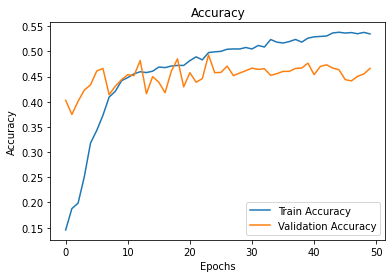

In [65]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

history.history['accuracy'][np.argmax(history.history['accuracy'])]

3.0714378356933594

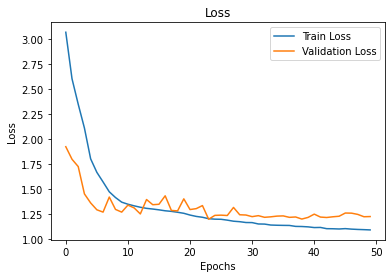

In [66]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

history.history['loss'][np.argmax(history.history['loss'])]

106.0


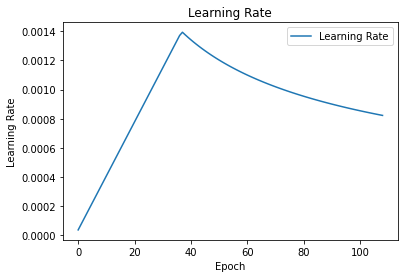

In [15]:
learning_rate = transformerSchedule(d_model, ramp_scalar=1, decay_scalar=1)
steps_per_epoch = np.ceil((np.shape(X_train)[0]/batch_size))
print(steps_per_epoch)
lr = np.array([])
for i in range(1, np.maximum(epochs+10, 30)):
    lr = np.append(lr, learning_rate.__call__((i*steps_per_epoch)))
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
plt.legend()


### Model Evaluation

In [68]:
epoch = np.argmax(history.history['val_accuracy'])
loss = history.history['loss'][epoch]
accuracy = history.history['accuracy'][epoch]
val_loss = history.history['val_loss'][epoch]
val_accuracy = history.history['val_accuracy'][epoch]
epoch += 1

print(f'best epoch: {epoch}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')

best epoch: 24, loss: 1.2063, accuracy: 0.4975, val_loss: 1.2010, val_accuracy: 0.4928


In [69]:
path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
test_model = get_compiled_model()
test_model.build((19072,22))
test_model.load_weights(path)

model_weights/weights.epoch:[24]-val_acc:[0.49].hdf5


In [70]:
pred = test_model.predict(X_test)

48/48 [==============================] - 1s 14ms/step


In [71]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def un_norm_cm(norm_cm):
    np.array([
        cm[i] / np.sum(cm[i]) for i in range(len(cm))
    ])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
def top_1_accuracy(cm):
    return (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
def top_2_accuracy(cm):
    return (cm.diagonal(-2).sum() + cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum() +
                 cm.diagonal(2).sum()) / cm.sum()

In [72]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))
print('+-1 accuracy', top_1_accuracy(cm))
print('+-2 accuracy', top_2_accuracy(cm))

accuracy 0.5039164490861618
+-1 accuracy 0.8929503916449086
+-2 accuracy 0.9804177545691906


Heatmap

<AxesSubplot:>

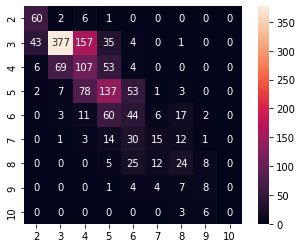

In [73]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

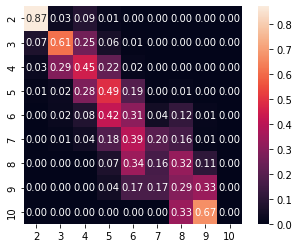

In [74]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)